In [453]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import numpy as np
import pandas as pd 
from Bio import SeqIO
from collections import Counter, defaultdict, OrderedDict
import nltk
from nltk.util import ngrams
import re
from sklearn.linear_model import Lasso, LinearRegression, SGDClassifier, LogisticRegression
import itertools 
import operator
import func_tools 
from sklearn.model_selection import cross_val_score
import pickle
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_regression
%matplotlib inline 

In [35]:
reload(func_tools)

<module 'func_tools' from 'func_tools.pyc'>

In [83]:
def word_grams(words, min_v=1, max_v=4):
    s = []
    for n in range(min_v, max_v):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

def build_letter_hist(rep, figsize=(5, 5), threshold=0):
    letter_counts = Counter(np.hstack(rep))
    letter_counts_new = drop_rare(letter_counts, threshold=threshold)
    df = pd.DataFrame.from_dict(letter_counts_new, orient='index')
    df.plot(kind='bar', figsize=figsize)

def merge_subarrays(arr):
    return np.hstack(arr)


def drop_rare(counter, threshold=0):
    for k in list(counter):
        if counter[k] < threshold:
            del counter[k]
    return counter


def calculate_prob(words, n=2):
    temp = np.array(list(words))
    result = {}
    for ngram in set(word_grams(words, min_v=n, max_v=n + 1)):
        ngram = ngram.replace(" ", "")
        ngram_positions = [m.start() for m in re.finditer('(?=' + ngram + ')', words)]
        letters_positions = np.array(ngram_positions) + len(ngram)
        letters_position = letters_positions[letters_positions < len(words)]
        counter = dict(Counter(temp[letters_position]))
        total = sum(counter.itervalues(), 0.0)
        counter = {k: 1.0 * v / total for k, v in counter.iteritems()}
        result[ngram] = counter
    return result


def id_to_read(filename):
    inp_seq = SeqIO.parse(filename, "fasta")
    inp_seq = list(inp_seq)
    read_id = [x.id for x in inp_seq]
    inp_reads = [str(x.seq) for x in inp_seq]
    id_to_read = {k: v for k, v in zip(read_id, inp_reads)}
    return id_to_read

def read_repertoire(filename):
    temp = list(SeqIO.parse(filename, "fasta"))
    return [str(x.seq) for x in temp]

def read_rcm(filename):
    rcm = open(filename)
    rcm = rcm.readlines()
    rcm = [x[:-1] for x in rcm]
    return dict(map(lambda x: x.split("\t"), rcm))

def construct_clusters(rcm_dict, id_dict):
    clusters = defaultdict(lambda: [])
    for value, key in rcm_dict.items():
        clusters[key].append(id_dict[value])
    return clusters


def max_character(arr):
    max_ch = 'A'
    for letter in arr:
        if max_ch < letter:
            max_ch = letter
    return max_ch


def min_character(arr):
    min_ch = 'Z'
    for letter in arr:
        if min_ch > letter:
            min_ch = letter
    return min_ch


def cluster_variety(cluster):
    letter_matrix = []
    res = defaultdict(lambda: 0)
    for read in cluster:
        letter_matrix.append(list(read))
    letter_matrix = list(itertools.izip_longest(*letter_matrix))
    for i, row in enumerate(letter_matrix):
        row = [x for x in row if x is not None]
        if max_character(row) != min_character(row):
            res[i] = Counter(row)
    return res


def second_vote(cluster):
    res = defaultdict(lambda: 0)
    for key, value in cluster_variety(cluster).items():
        temp = sorted(value.values())
        res[key] = 1.0 * temp[-2] / len(cluster)
    return res


def major_vote(cluster):
    ans = list(max(cluster, key=len))
    res = {}
    for key, value in cluster_variety(cluster).items():
        temp = sorted(value.items(), key=lambda x: x[1])
        res[key] = temp[-1][0]
    for key in res:
        ans[key] = res[key]
    return ''.join(ans)


def second_votes(clusters):
    res = {}
    for key in clusters:
        res[key] = second_vote(clusters[key])
    return res


def clusters_size_dict(clusters):
    clusters_lenghts = {}
    for key in clusters:
        clusters_lenghts[key] = len(clusters[key])
    return clusters_lenghts


def top_massive_clusters(clusters, res_dict, n=10):
    clusters_lenghts = clusters_size_dict(clusters)
    top_n = [x[0] for x in sorted(clusters_lenghts.items(), key=lambda x: x[1])[-n:]]
    res = []
    fig, axes = plt.subplots(ncols=5, nrows=(n - 1) / 5 + 1, figsize=(20, 10))
    for j, key in enumerate(top_n):
        if not j % 5:
            axes[j / 5, j % 5].set_ylabel('Second Vote')
        res1 = [0] * 500
        for i in range(500):
            res1[i] += res_dict[str(key)][i] / n
        res.append(res1[:])
        axes[j / 5, j % 5].scatter(range(500), res1)
        axes[j / 5, j % 5].set_ylim((0, 0.008))
        axes[j / 5, j % 5].set_xlabel('Position')

    return res

def precision_sensetivity_F1(constructed, reference):
    ref = set(reference)
    con = set(constructed)
    
    ref_con_intersection = ref.intersection(con)
    
    precision = 1.0 * len(ref_con_intersection) / len(con)
    sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
    
    return 2.0 * precision * sensitivity / (precision + sensitivity) 

def split_cluster(cluster, position):
    """
    Try some other variants
    :param cluster:
    :param position:
    :return:
    """

    position_variation = cluster_variety(cluster)[position]
    if not position_variation:
        return [cluster, []]
    letter_for_split = find_max_dict(position_variation)
    first_splitted_part = []
    second_splitted_part = []

    for item in cluster:
        if item[position] == letter_for_split:
            first_splitted_part.append(item)
        else:
            second_splitted_part.append(item)
            
    if len(first_splitted_part) < 5 and len(second_splitted_part) < 5:
        return [[],[]]
    
    elif len(first_splitted_part) < 5 and len(second_splitted_part) >= 5:
        return [second_splitted_part, []]
    
    elif len(first_splitted_part) >= 5 and len(second_splitted_part) < 5:
        return [first_splitted_part, []]
    
    else:
        return (first_splitted_part, second_splitted_part)

def split_by_2nd_vote(cluster):
    max_2nd_vote_pos = find_max_dict(second_vote(cluster))
    return split_cluster(cluster, max_2nd_vote_pos)


def find_max_dict(dictionary):
    return max(dictionary.iteritems(), key=operator.itemgetter(1))[0]

def clusters2rep(clusters):
    rep = {}
    for key in clusters:
        rep[key] = (major_vote(clusters[key]))
    return rep

def quality(constructed_rep, reference, type='sum'):

    if type == 'sum':
        ref = set(reference)
        con = set(constructed_rep)
        
        ref_con_intersection = ref.intersection(con)
    
        precision = 1.0 * len(ref_con_intersection) / len(con)
        sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
        return (precision + sensitivity)/2
    
    elif type == 'F1':
        return precision_sensetivity_F1(constructed_rep, reference)
    
    elif type == 'mult':
        ref = set(reference)
        con = set(constructed_rep)
        
        ref_con_intersection = ref.intersection(con)
    
        precision = 1.0 * len(ref_con_intersection) / len(con)
        sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
        return precision * sensitivity
        
        
def clusters_classification(clusters, reference, constructed_rep):
    print "Repertoire construction started"
    #constructed_rep = clusters2rep(clusters)
    print "END"
    quality_0 = quality(constructed_rep.values(), reference)
    res = {}
    new_num = max([int(key) for key in clusters.keys()]) + 1 
    for i, key in enumerate(clusters):
        if i%1000 == 0:
            print i
        if not second_vote(clusters[key]):
            res[key] = 0
            continue
        first_part, second_part = split_by_2nd_vote(clusters[key])
        temp_clusters = constructed_rep.copy()
        temp_clusters[key] = major_vote(first_part)
        temp_clusters[new_num] = major_vote(second_part)
        curr_quality = precision_sensetivity_F1(temp_clusters.values(), reference)
        if curr_quality > quality_0:
            quality_0 = curr_quality
            res[key] = 1
        elif curr_quality < quality_0:
            res[key] = -1
        else:
            res[key] = 0
    return res 

def simple_clusters_classification(clusters, reference, constructed_rep):
    ref = set(reference)
    res = {}
    for i, key in enumerate(clusters):

        if i%100 == 0:
            print i
            
        if not second_vote(clusters[key]):
            res[key] = -1
            continue
            
        first_part, second_part = split_by_2nd_vote(clusters[key])
        first_cons, second_cons = major_vote(first_part), major_vote(second_part)
        cluster_major = major_vote(clusters[key])
        
        if cluster_major in ref: 
            if ((first_cons in ref) and (second_cons not in ref)) or ((second_cons in ref) and (first_cons not in ref)):
                res[key] = -1

            elif ((first_cons in ref) and (second_cons in ref)):
                res[key] = 1

            elif ((first_cons not in ref) and (second_cons not in ref)):
                res[key] = -1
        else:
            if ((first_cons in ref) and (second_cons not in ref)) or ((second_cons in ref) and (first_cons not in ref)):
                res[key] = 1

            elif ((first_cons in ref) and (second_cons in ref)):
                res[key] = 1

            elif ((first_cons not in ref) and (second_cons not in ref)):
                res[key] = -1
    return res 
            
        
def clusters_filtering(clusters, threshold=5):
    filtered_clusters = {}
    for key in clusters:
        if len(clusters[key]) > threshold:
            filtered_clusters[key] = clusters[key]
    return filtered_clusters

In [3]:
read_seq = SeqIO.parse("/Users/Macbook/GitHub/ig_repertoire_constructor/igrec_test/final_repertoire.fa", "fasta")

In [4]:
rep = [np.array(seq.seq) for seq in read_seq] 

(array([  6.,  10.,  31.,  59.,  88.,  91.,  31.,  14.,  10.,   4.]),
 array([ 337. ,  343.6,  350.2,  356.8,  363.4,  370. ,  376.6,  383.2,
         389.8,  396.4,  403. ]),
 <a list of 10 Patch objects>)

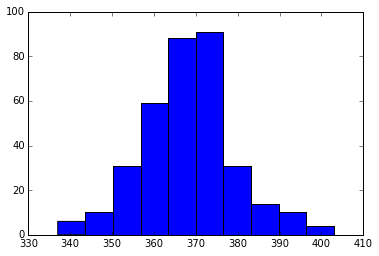

In [60]:
plt.hist([len(item) for item in rep])

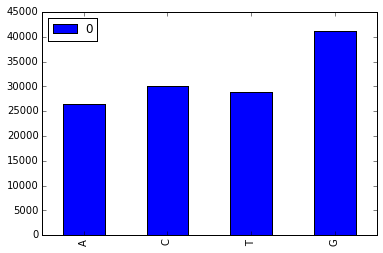

In [61]:
letter_counts = Counter(np.hstack(rep))
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

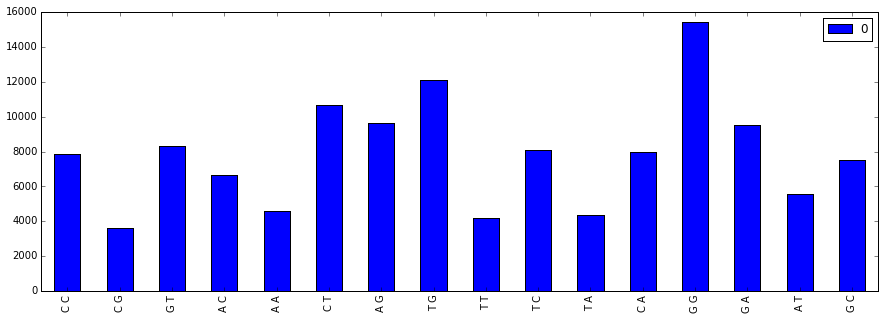

In [98]:
two_grams = map(lambda x: word_grams(x, min=2, max=3), rep)
build_letter_hist(two_grams, figsize=(15,5))

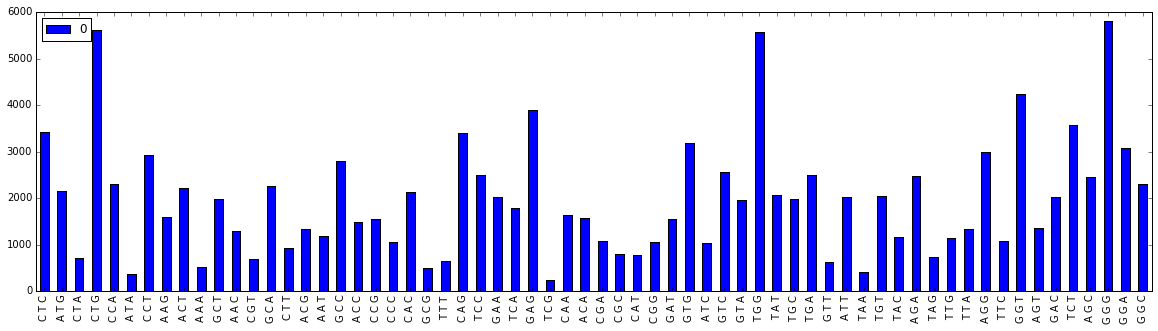

In [99]:
three_grams = map(lambda x: word_grams(x, min=3, max=4), rep)
build_letter_hist(three_grams, figsize=(20, 5))

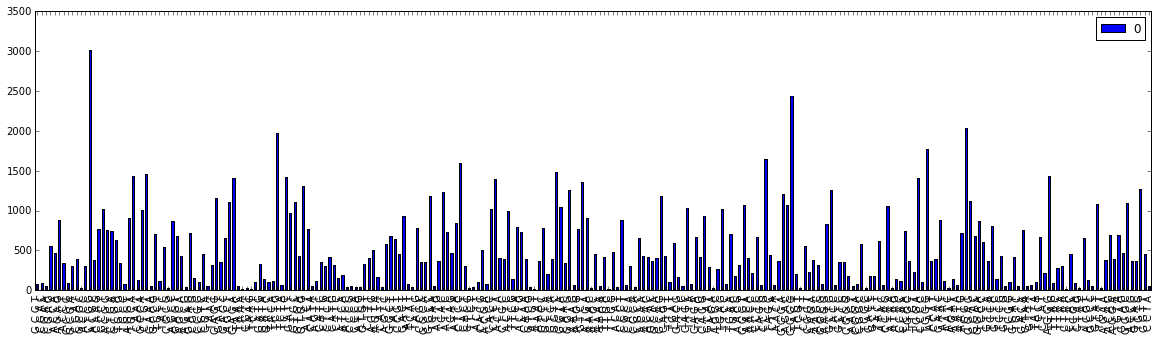

In [100]:
four_grams = map(lambda x: word_grams(x, min=4, max=5), rep)
build_letter_hist(four_grams, figsize=(20, 5))

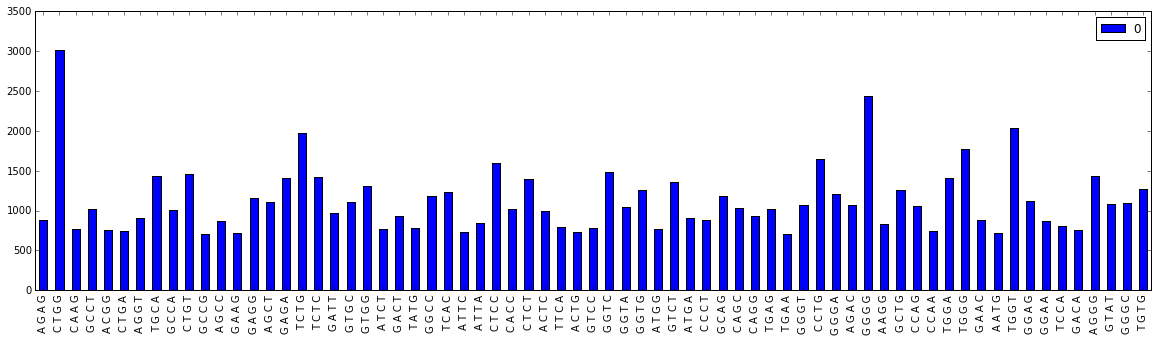

In [101]:
build_letter_hist(four_grams, figsize=(20, 5), threshold=700)

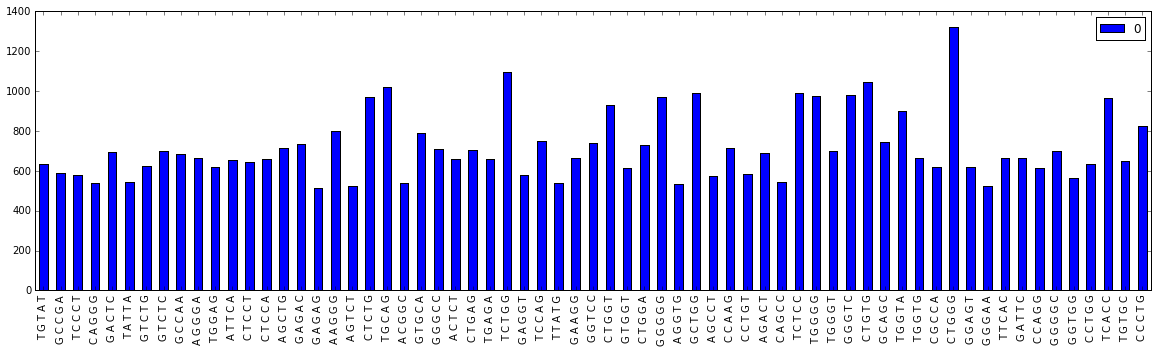

In [103]:
five_grams = map(lambda x: word_grams(x, min=5, max=6), rep)
build_letter_hist(five_grams, figsize=(20, 5), threshold=500)

Очень много 6-мер повторяются примерно одинаковое количество раз и есть не так много (20-30) 6-мер, которые под это правило не подходят 

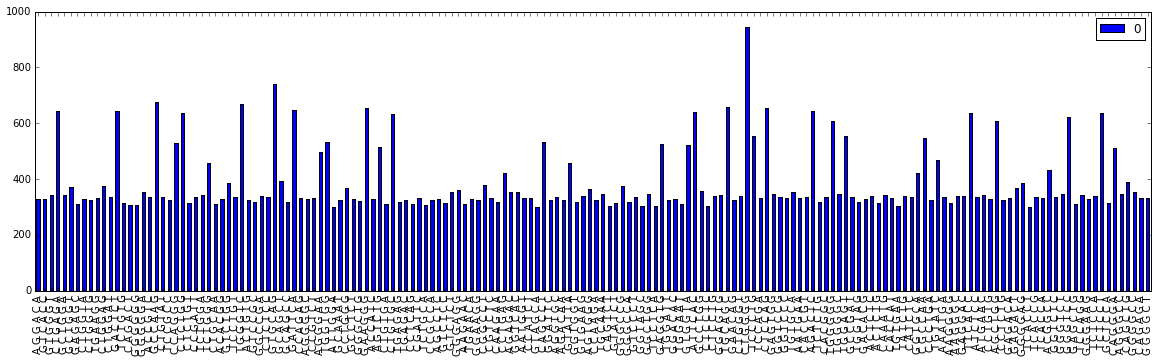

In [315]:
six_grams = map(lambda x: word_grams(x, min=6, max=7), rep)
build_letter_hist(six_grams, figsize=(20, 5), threshold=300)

In [141]:
seven_grams = map(lambda x: word_grams(x, min=7, max=8), rep)
build_letter_hist(seven_grams, figsize=(20, 5), threshold=300)

ERROR! Session/line number was not unique in database. History logging moved to new session 299


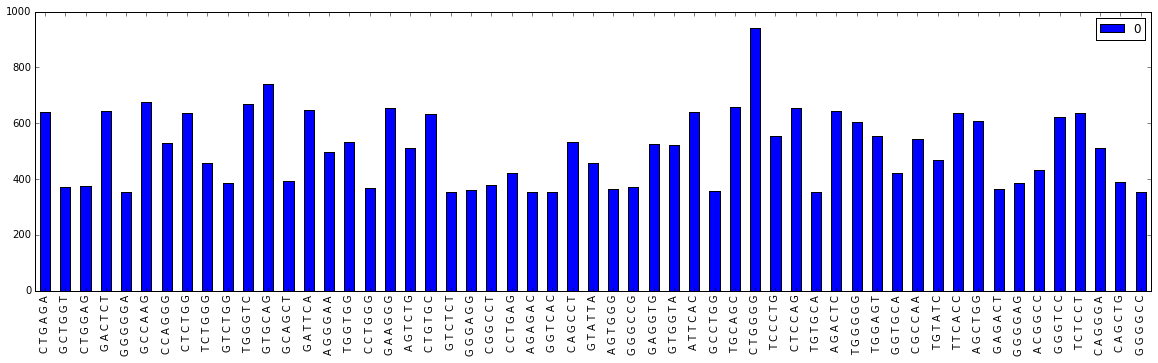

In [109]:
build_letter_hist(six_grams, figsize=(20, 5), threshold=350)

# INPUT 

In [21]:
# id_dict - dict with ids -> read
# rep - reference repertoire, array of reads
# rcm - reference repertoire, dict with ids -> cluster number
id_dict = func_tools.id_to_read('data/age3/input_reads.fa')
rep = func_tools.read_repertoire('data/age3/repertoire.fa')
rcm = func_tools.read_rcm("data/age3/repertoire.rcm")

In [50]:
# clusters - dict with ids -> array of read included in this cluster
clusters = construct_clusters(rcm, id_dict)

In [51]:
# final_rcm - final clusters description 
final_rcm = read_rcm('final_repertoire.rcm')

In [119]:
# dict with ids -> array of read included in this cluster
final_clusters = construct_clusters(final_rcm, id_dict)

In [120]:
# final_rep - final repertoire constructed by igrec
final_rep = clusters2rep(clusters_filtering(final_clusters))

In [121]:
# final_res - same as res calculated for igrec results 
final_res = second_votes(clusters_filtering(final_clusters))

In [54]:
# res - dict with second votes calculated for every position in cluster
# final_res - same as res calculated for igrec results 
res = second_votes(clusters)
final_res = second_votes(clusters_filtering(final_clusters))

In [125]:
with open('final_clusters.pkl', 'wb') as output:
    pickle.dump(dict(clusters_filtering(final_clusters)), output, pickle.HIGHEST_PROTOCOL)

with open('final_rep.pkl', 'wb') as output:
    pickle.dump(dict(final_rep), output, pickle.HIGHEST_PROTOCOL)

with open('final_res.pkl', 'wb') as output:
    pickle.dump({k:dict(v) for k,v in final_res.items()}, output, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('/Users/Macbook/GitHub/ig_cluster_splitter/data/age3/final_clusters.pkl', 'rb') as inputio:
    final_clusters = pickle.load(inputio)
with open('/Users/Macbook/GitHub/ig_cluster_splitter/data/age3/final_rep.pkl', 'rb') as inputio:
    final_rep = pickle.load(inputio)
with open('/Users/Macbook/GitHub/ig_cluster_splitter/data/age3/final_res.pkl', 'rb') as inputio:
    final_res = pickle.load(inputio)

Гистограмма для распределения second vote внутри одного из кластеров 

<Container object of 358 artists>

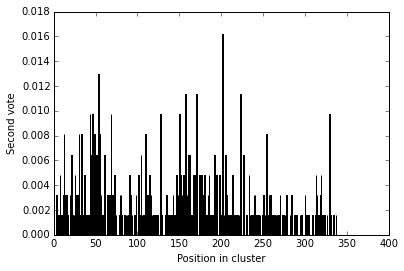

In [55]:
fig = plt.figure()
temp_dict = second_vote(clusters['4'])
temp_arr = [temp_dict[x] for x in range(len(clusters['4'][0]))]
plt.ylabel('Second vote')
plt.xlabel('Position in cluster')
plt.bar(range(len(clusters['4'][0])), temp_arr)
#fig.savefig('second_vote.pdf', format='pdf')

<Container object of 349 artists>

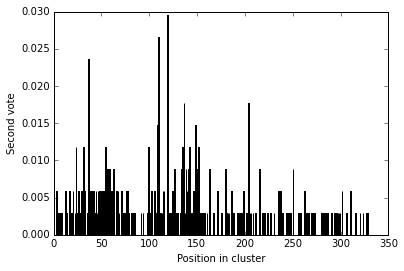

In [56]:
fig = plt.figure()
temp_dict = second_vote(clusters['11'])
temp_arr = [temp_dict[x] for x in range(len(clusters['11'][0]))]
plt.ylabel('Second vote')
plt.xlabel('Position in cluster')
plt.bar(range(len(clusters['11'][0])), temp_arr)
#fig.savefig('second_vote.pdf', format='pdf')

Гистограмма для распределения для second vote 
Видно, что много кластеров имеют second vote ~ 0.5

(0, 0.6)

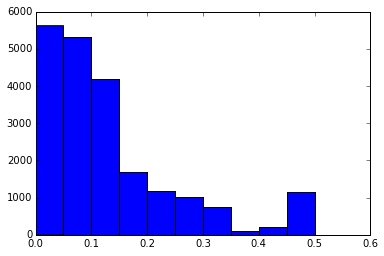

In [97]:
res1 = []
for key in res:
    res1.append(np.max(res[key].values()) if len(res[key].values()) else 0)
plt.hist(res1)
plt.xlim((0, 0.6))

<Container object of 500 artists>

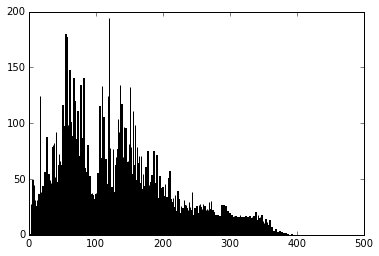

In [16]:
res1 = [0]*500
for key in range(21200):
    for i in range(500):
        if res_dict[str(key)][i] > 0.05:
            res1[i] += res_dict[str(key)][i]
plt.bar(range(500), res1)

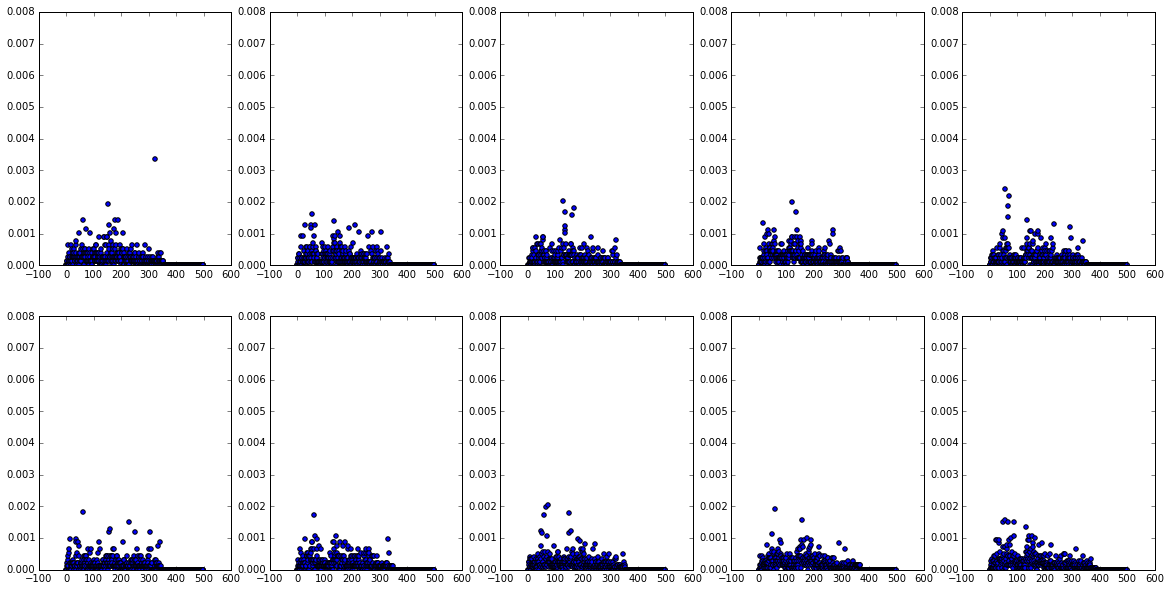

In [32]:
top_10 = top_massive_clusters(clusters, 10)

<Container object of 500 artists>

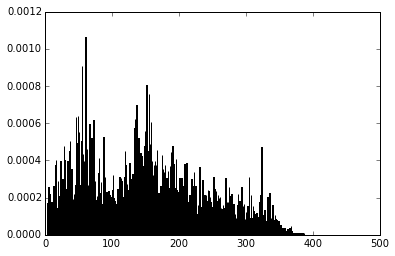

In [54]:
plt.bar(range(500), np.mean(top_10, axis=0))

In [49]:
max_second_vote = {key:(np.max(res[key].values()) if len(res[key].values()) else 0) for key in res}

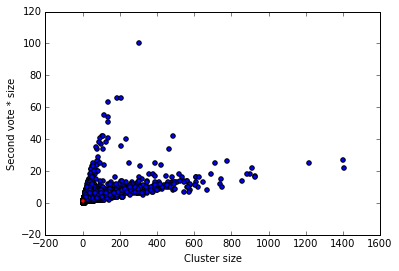

In [88]:
dots = [] 
sizes = clusters_size_dict(clusters)
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_second_vote[key], clf_f1[key]))
plt.scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b')
plt.scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
plt.scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r')
plt.ylabel("Second vote * size")
plt.xlabel("Cluster size")

(0, 10)

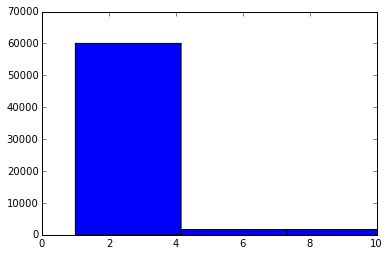

In [103]:
plt.hist(clusters_size_dict(final_clusters).values(), bins=400)
plt.xlim((0, 10))

In [30]:
major_vote(final_clusters['1'])

'CAGCTGCAGCTGCAGGAGTCGGGCCCAGGCCTAGTGAAGCCTTCGGAGACCCTCTCCCTCACCTGCAATGTCTCCGGTGACTCCGTCAGCGGTAGTTTTTACTCCTGGGCCTGGATACGACAGTCCCCAGGGAGGGGACTGGAGTGGATTGGAAGTGTCTCTTCCAGTAGGACCCCTTACTACAACCCGTCTTTCAAAAGTCAAGTCAGCATATCCAGAGACACGTCCAAGAACCAATTCACCCTGCAGTTGACCGCTGTGACCGCCGCGGACATGGCCGTTTATTATTGTGCGAGAGAGGGCGGGAGTTACCTCCTTAACTTCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG'

In [42]:
c = set()
for key in final_clusters:
    if len(final_clusters[key]) < 5 and major_vote(final_clusters[key]) in rep:
        c.add(major_vote(final_clusters[key]))

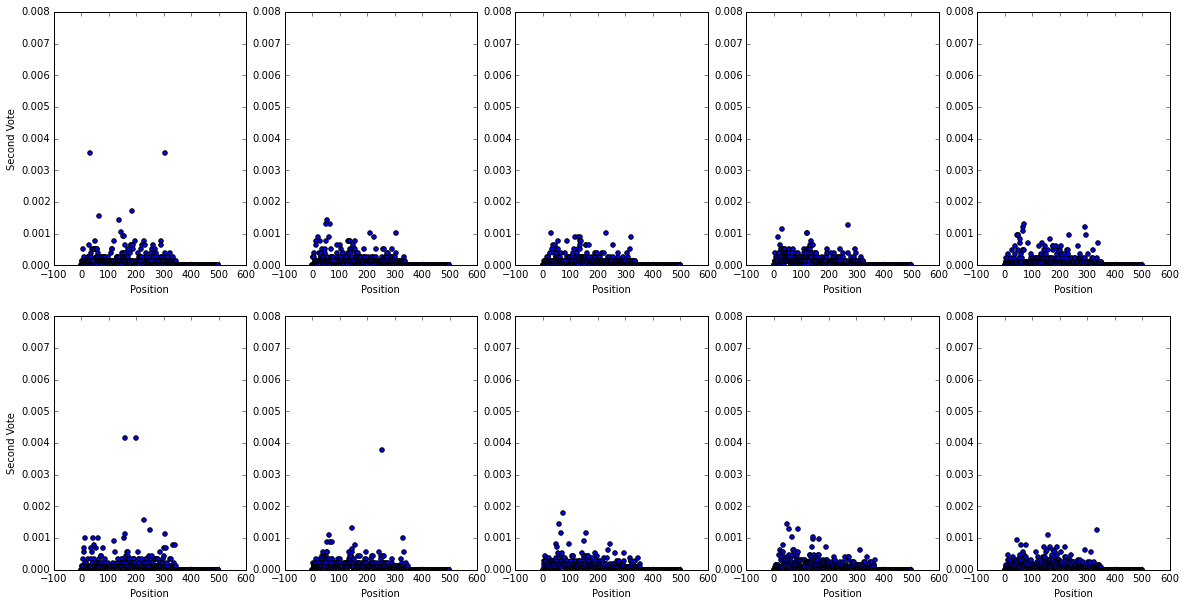

In [61]:
top_fin_10 = top_massive_clusters(final_clusters, final_res)

<Container object of 500 artists>

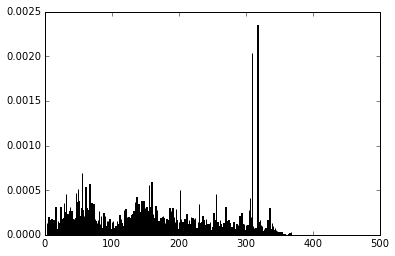

In [62]:
plt.bar(range(500), np.mean(top_fin_10, axis=0))

In [67]:
max_final_second_vote = {key:(np.max(final_res[key].values()) if len(final_res[key].values()) else 0) for key in final_res}

10

In [ ]:
dots = [] 
sizes = clusters_size_dict(clusters_filtering(final_clusters))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_final_second_vote[key], final_clf_sum[key]))
axes[0].scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b', label='Quality decreased')
axes[0].scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
axes[0].scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r', label='Quality increased')

classifier = Lasso()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
axes[0].plot(range(1000),np.poly1d(classifier.coef_)(range(1000)))

classifier = SGDClassifier()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
for coef_ in classifier.coef_:
    axes[0].plot(range(1000),np.poly1d(coef_)(range(1000)))

axes[0].legend()
axes[0].set_xlim((-1, 1300))
axes[0].set_ylim((-1, 200))
axes[0].set_ylabel("Second vote * size")
axes[0].set_xlabel("Cluster size")

axes[1].hist(final_clf_sum.values())

fig.savefig('graph.pdf', format='pdf')

In [11]:
ans = simple_clusters_classification(clusters_filtering(final_clusters), rep)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500


In [12]:
with open('ans_dict.pkl', 'wb') as output:
    pickle.dump(dict(ans), output, pickle.HIGHEST_PROTOCOL)

In [154]:
max_final_second_vote = {key:(np.max(final_res[key].values()) if len(final_res[key].values()) else 0) for key in final_res}

(array([ 13974.,      0.,      0.,      0.,      0.,     29.,      0.,
             0.,      0.,    512.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

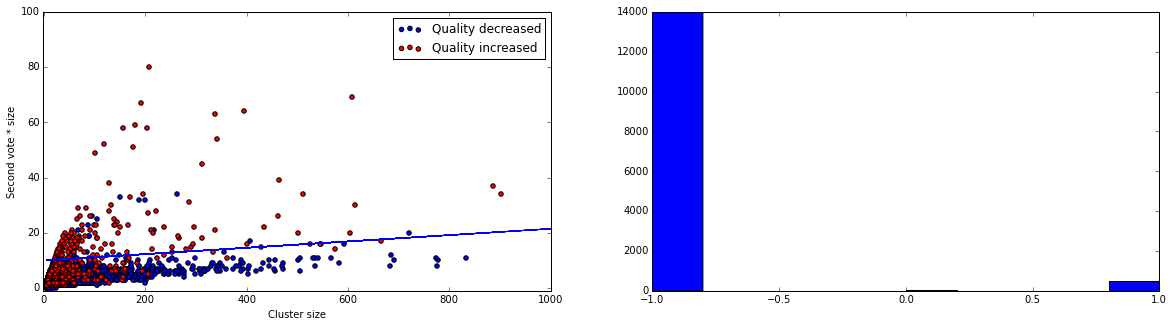

In [171]:
dots = [] 
sizes = clusters_size_dict(clusters_filtering(final_clusters))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_final_second_vote[key], r[key] if r[key] else -1))
axes[0].scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b', label='Quality decreased')
axes[0].scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
axes[0].scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r', label='Quality increased')

classifier = LogisticRegression()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2])

def log_func(x):
    return (-classifier.intercept_ - classifier.coef_[0][0] * x)/classifier.coef_[0][1]
axes[0].plot(np.array(dots)[:,0], map(log_func, np.array(dots)[:,0]))

axes[0].legend()
axes[0].set_xlim((-1, 1000))
axes[0].set_ylim((-1, 100))
axes[0].set_ylabel("Second vote * size")
axes[0].set_xlabel("Cluster size")

axes[1].hist(r.values())

In [176]:
cross_val_score(classifier, np.array(dots)[:,[0,1]], np.array(dots)[:,2], cv=5).mean()

0.97278705455532832

# AGE3 Dataset

In [139]:
df = build_df_test(igrec_clusters=clusters_filtering(final_clusters),
              igrec_rep=final_rep,
              igrec_res=final_res)

build_df started
calculation step
parsing step
context step
mutation step
building succeeded


In [29]:
df = pd.read_csv('data/age3/first_df.csv', index_col='Unnamed: 0')
df = df.drop(['CDR1_end.1', 'CDR2_end.1', 'CDR3_end.1', 'CDR1_end', 'CDR2_end', 'CDR3_end'], axis=1)

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


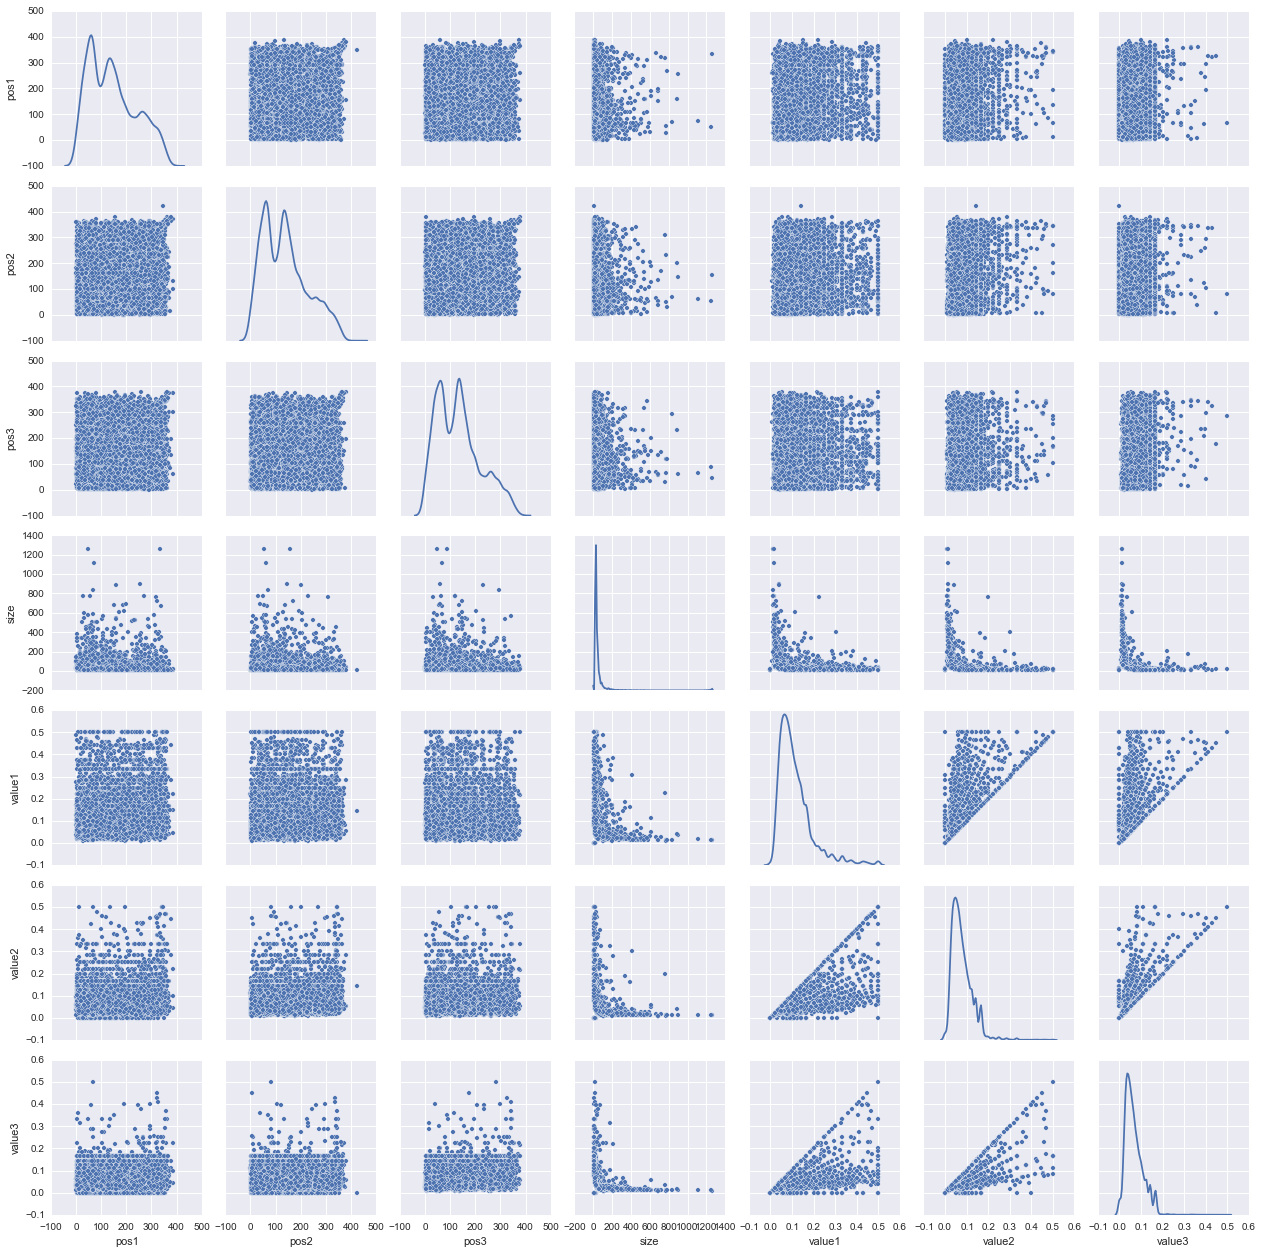

In [145]:
sb.pairplot(df, diag_kind='kde')

In [26]:
cdr_df = pd.read_csv('data/age3/cdr/cdr_details.txt', delimiter='\t')

/Users/Macbook/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
cdr = cdr_df[['CDR1_start', 'CDR2_start', 'CDR3_start', 'CDR1_end', 'CDR2_end', 'CDR3_end']]

In [30]:
new_df = pd.concat([df, cdr], axis=1).dropna()

In [31]:
new_df.head()

context1  context2  context3  context4  context5  mutated_letter   pos1  \
0       3.0       3.0       3.0       3.0       2.0             4.0   44.0   
2       3.0       4.0       3.0       2.0       1.0             4.0   66.0   
5       3.0       3.0       3.0       1.0       2.0             1.0  353.0   
7       2.0       4.0       2.0       3.0       3.0             1.0   49.0   
8       1.0       2.0       3.0       3.0       2.0             4.0  275.0   

    pos2   pos3  size    value1    value2    value3  CDR1_start  CDR2_start  \
0   19.0    7.0  52.0  0.038462  0.038462  0.019231          76         151   
2   36.0  108.0  27.0  0.148148  0.074074  0.074074          76         151   
5  230.0  155.0  23.0  0.130435  0.086957  0.086957          76         151   
7  162.0  323.0  15.0  0.200000  0.066667  0.066667          76         151   
8  150.0  317.0  59.0  0.050847  0.033898  0.033898          76         157   

  CDR3_start  CDR1_end  CDR2_end CDR3_end  
0        289        99       174      315  
2        289        99       174      321  
5        286        99       171      342  
7        289        99       174      333  
8        292       105       177      360

In [200]:
coder = LabelEncoder()
coder.fit(new_df['context1'])
new_df.context1 = coder.transform(new_df['context1'])
new_df.context2 = coder.transform(new_df['context2'])
new_df.context3 = coder.transform(new_df['context3'])
new_df.context4 = coder.transform(new_df['context4'])
new_df.context5 = coder.transform(new_df['context5'])
new_df.mutated_letter = coder.transform(new_df['mutated_letter'])

new_df.CDR3_start = new_df.CDR3_start.map(int)
new_df.CDR3_end = new_df.CDR3_end.map(int)

## Heatmap

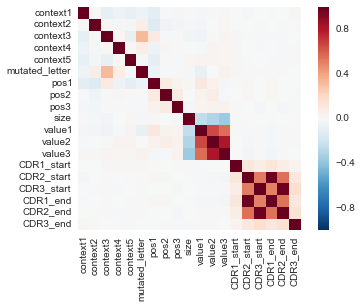

In [208]:
fig = plt.figure()
sb.heatmap(new_df.corr(), square=True)
fig.savefig('heatmap.pdf', format='pdf')

In [250]:
new_df.CDR3_start = new_df.CDR3_end.map(int)

## tSNE

In [ ]:
data = scale(new_df)
tsne = TSNE(n_components=2, init='pca', random_state=321)
tsne_representation = tsne.fit_transform(data)

In [72]:
tsne_representation = np.fromfile('tsne_rep.npy')

In [93]:
tsne_representation = tsne_representation.reshape(len(tsne_representation)/2, 2)

In [133]:
tsne_representation

array([[  1.87585069e-309,   1.17119999e+171],
       [  5.22741680e-037,   8.44740097e+252],
       [  2.65141232e+180,   9.92152605e+247],
       ..., 
       [ -5.23094921e-001,  -9.94869598e-001],
       [ -2.23033346e+000,   3.64935438e+000],
       [ -2.88330638e+000,  -6.82663093e+000]])

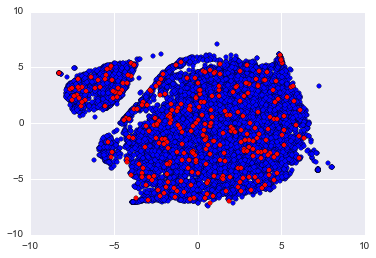

In [169]:
dots = np.array(zip(tsne_representation, list(full_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')
plt.xlim((-10, 10))
plt.ylim(-10, 10)
fig.savefig('tSNEd.png', format='png')

## Pair Plots

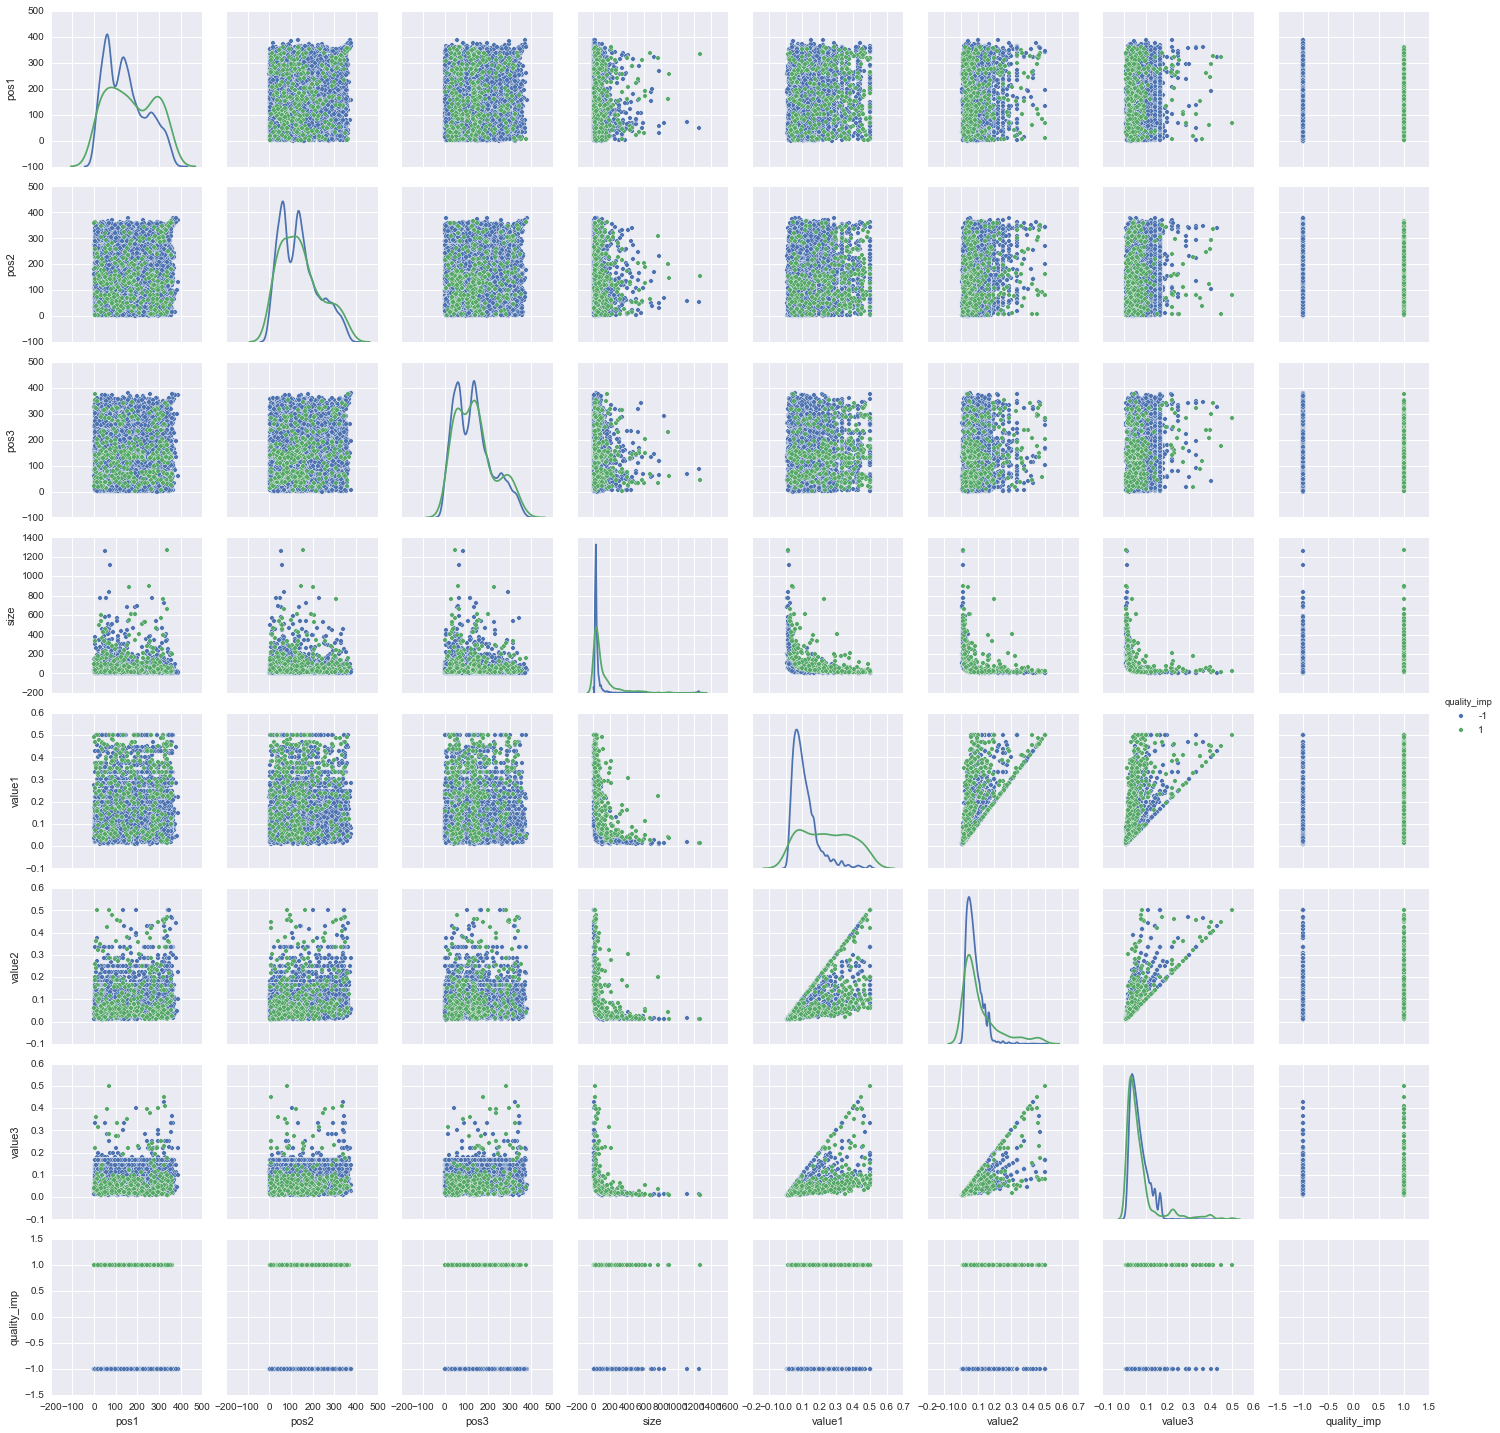

In [235]:
sb.pairplot(full_df.drop(list(full_df.columns[:6])+
             ['first_cluster', 'origin_cluster', 'second_cluster']+
             ['CDR1_start', 'CDR2_start', 'CDR3_start']+
             ['CDR1_end', 'CDR2_end', 'CDR3_end'], axis=1), 
            hue='quality_imp',
            diag_kind='kde')

## PCA

In [251]:
pca = PCA(n_components=19)

In [328]:
pca_representation = pca.fit_transform(scale(full_df[full_df.columns[:-4]]))

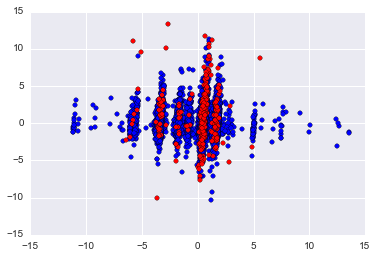

In [329]:
dots = np.array(zip(pca_representation, list(full_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')
#fig.savefig('tSNEd.png', format='png')

<Container object of 19 artists>

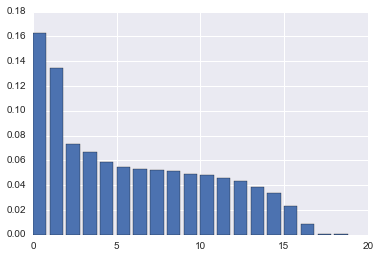

In [341]:
plt.bar(range(19), pca.explained_variance_ratio_)

In [340]:
print full_df[full_df.columns[:-4]].columns[[14,15,16,17]]
print full_df[full_df.columns[:-4]].columns[[9,10,11,12]]

Index([u'CDR2_start', u'CDR3_start', u'CDR1_end', u'CDR2_end'], dtype='object')
Index([u'size', u'value1', u'value2', u'value3'], dtype='object')


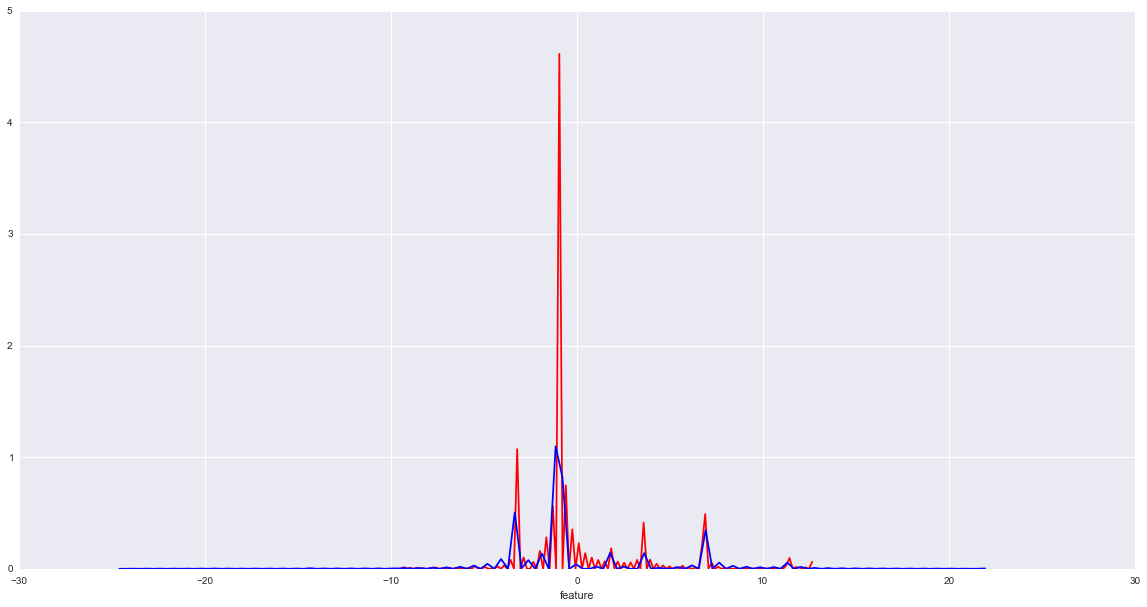

In [394]:
temp_df = pd.DataFrame(zip(scale(full_df[['CDR2_start', 'CDR3_start', 'CDR1_end', 'CDR2_end']]).sum(axis=1), 
 full_df.quality_imp.values), columns=['feature', 'class'])
plt.figure(figsize=(20,10))
sb.distplot(temp_df[temp_df['class']==1].feature, hist=False, color='r')
sb.distplot(temp_df[temp_df['class']==-1].feature, hist=False, color='b')

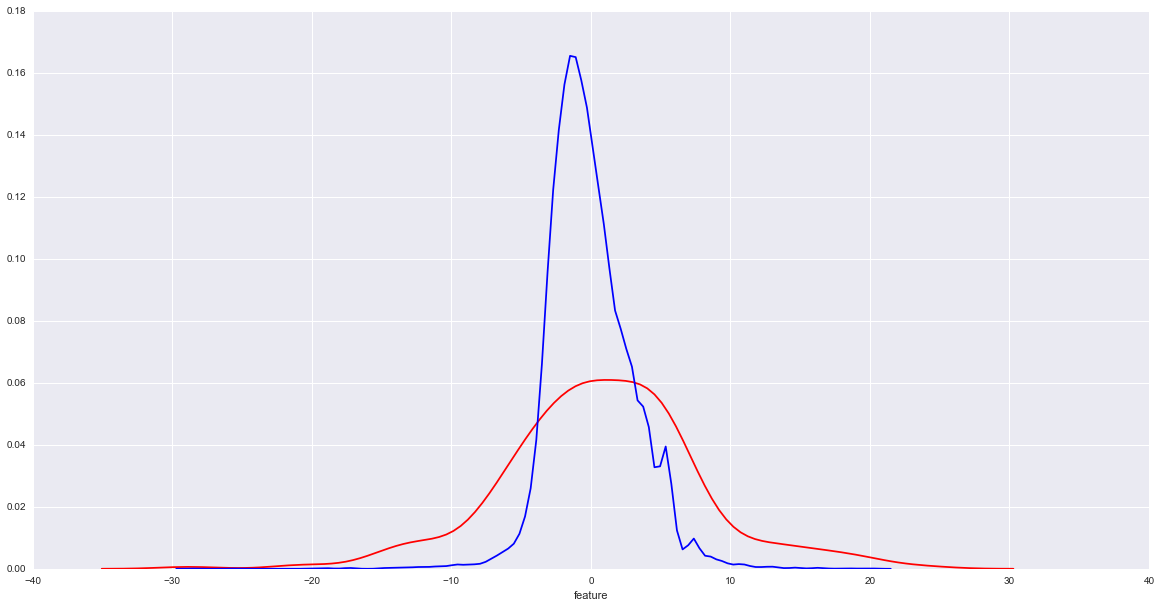

In [401]:
temp_df = pd.DataFrame(zip(scale(full_df[['value1', 'value2', 'value3']]).sum(axis=1) - scale(full_df['size']), 
 full_df.quality_imp.values), columns=['feature', 'class'])
plt.figure(figsize=(20,10))
sb.distplot(temp_df[temp_df['class']==1].feature, hist=False, color='r')
sb.distplot(temp_df[temp_df['class']==-1].feature, hist=False, color='b')

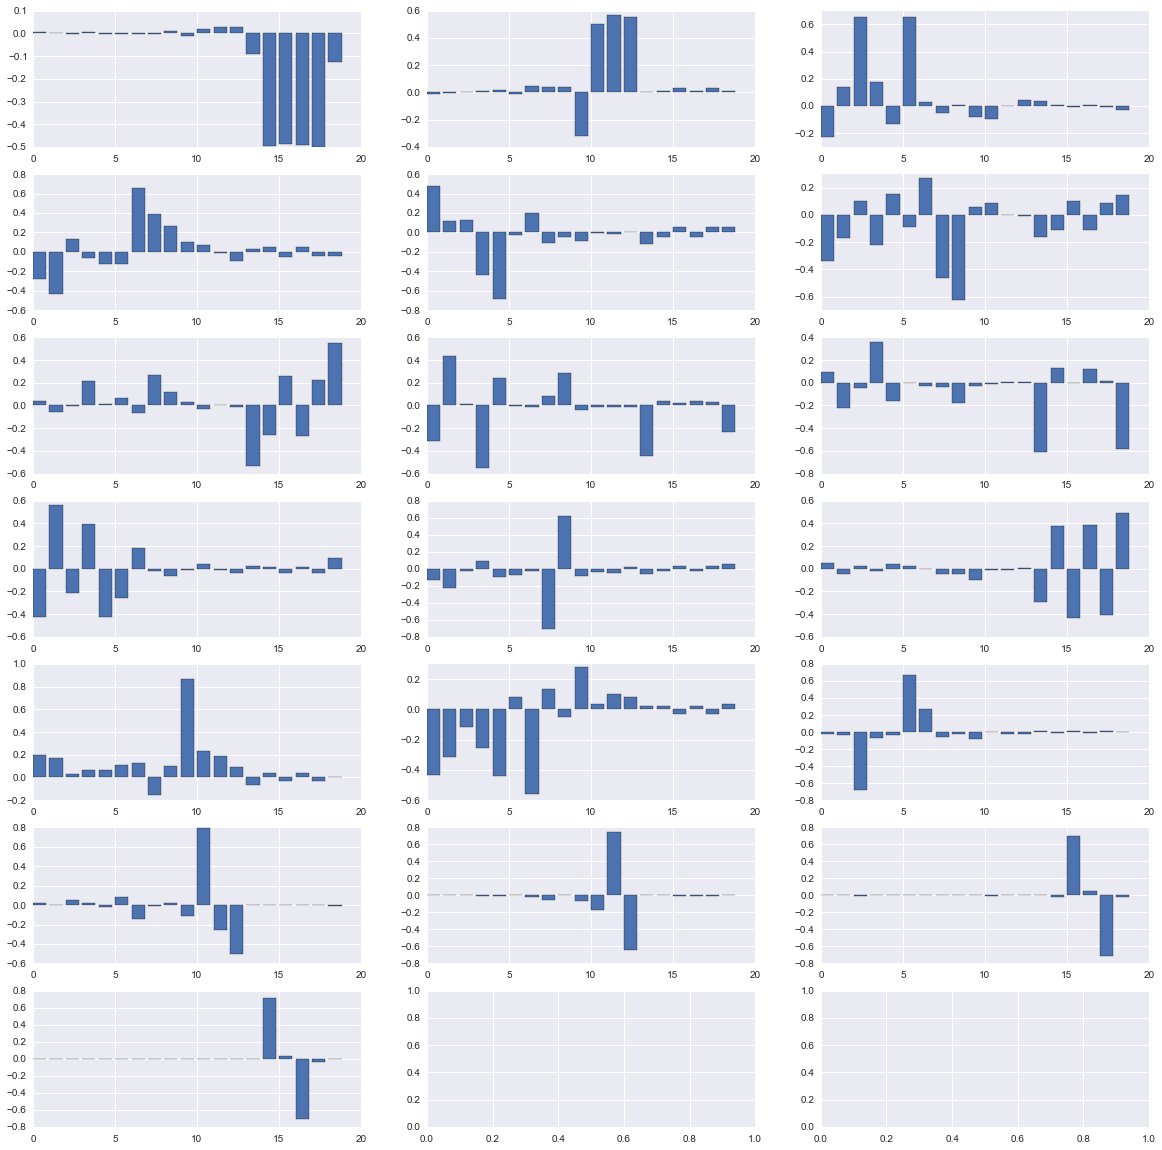

In [331]:
fig, axes = plt.subplots(ncols=3, nrows=7, figsize=(20, 20))
for i, vec in enumerate(np.identity(19)): 
    axes[i/3, i%3].bar(range(19),pca.inverse_transform(vec.T))

In [418]:
df = func_tools.build_df_test(igrec_clusters=clusters_filtering(final_clusters),
              igrec_rep=final_rep,
              igrec_res=final_res)

build_df started
calculation step
parsing step
context step
mutation step
building succeeded


In [431]:
df.index = df.index.map(int)

In [439]:
df = pd.concat([df, ans_df], axis=1)

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


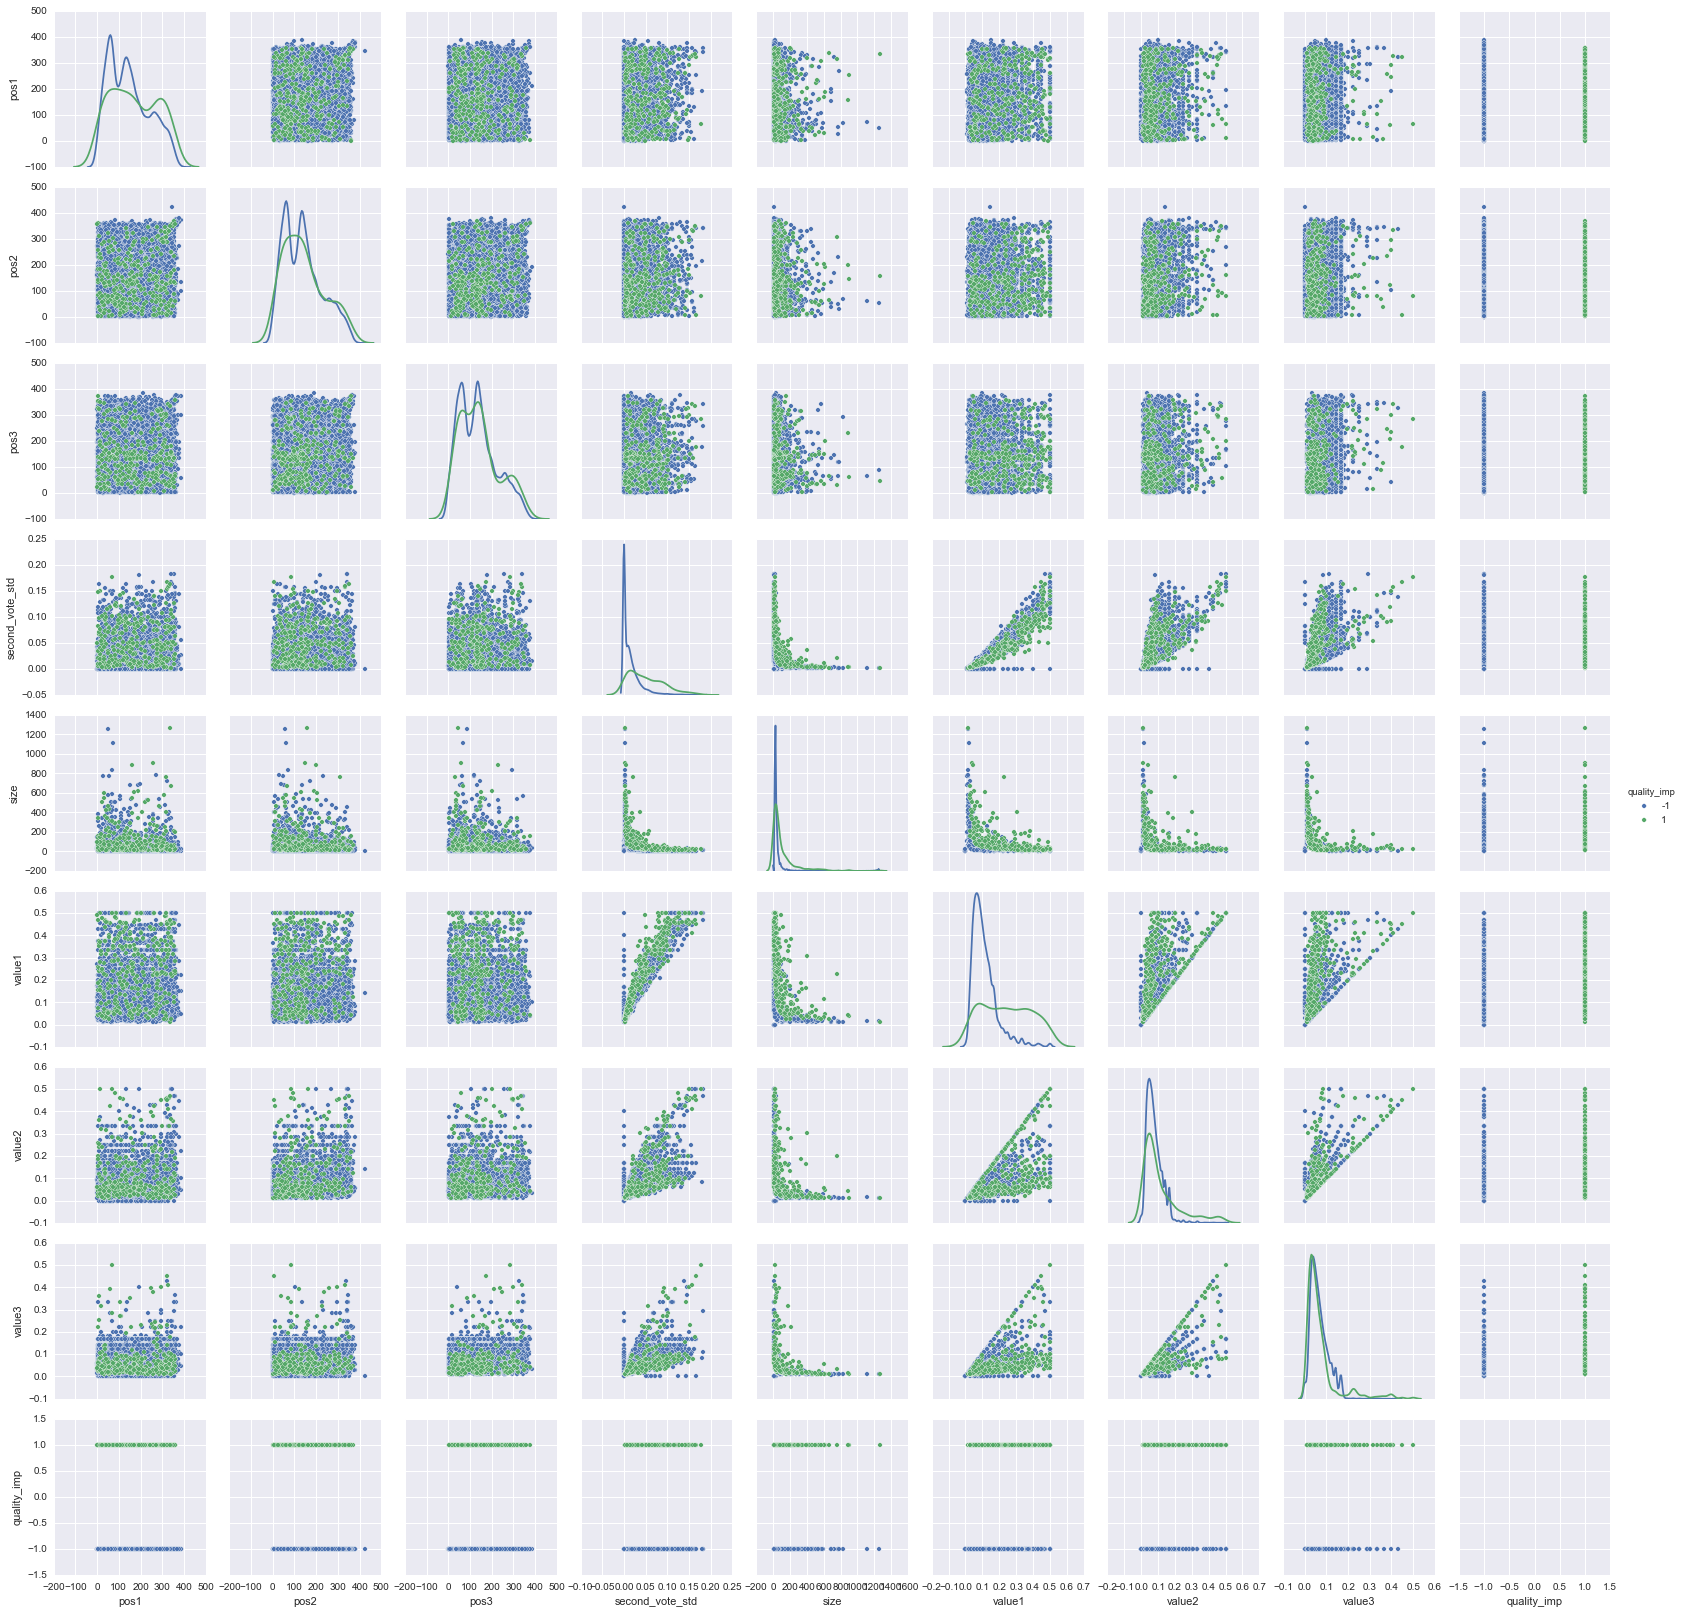

In [442]:
sb.pairplot(df.drop(list(df.columns[:6])+
             ['first_cluster', 'origin_cluster', 'second_cluster'], axis=1), 
            hue='quality_imp',
            diag_kind='kde')

In [24]:
ans_df = func_tools.build_ans_df(ans)

In [34]:
df = func_tools.build_df_preload(final_clusters, final_rep, final_res)

build_df started
calculation step


/Users/Macbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Macbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Macbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


parsing step
context step
mutation step
building succeeded


In [42]:
final_df = pd.concat([df, cdr, ans_df], axis=1)
final_df = final_df.dropna()

In [44]:
final_df.to_csv('age3_df.csv')

# FLU DATASET

In [ ]:
df_flu = func_tools.build_df(input_reads='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/input_reads.fa',
                    fa_reference='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/repertoire.fa',
                    rcm_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/final_repertoire.rcm',
                    cdr_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/cdr/cdr_details.txt')

In [ ]:
df_flu.to_csv('flu_df.csv')

In [29]:
input_reads='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/input_reads.fa'
fa_reference='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/repertoire.fa'
rcm_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/final_repertoire.rcm'
cdr_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/cdr/cdr_details.txt'

In [36]:
id_dict = func_tools.id_to_read(input_reads)

In [37]:
rep = func_tools.read_repertoire(fa_reference)

In [38]:
igrec_rcm = func_tools.read_rcm(rcm_file)

In [39]:
igrec_clusters = func_tools.construct_clusters(igrec_rcm, id_dict)

In [40]:
igrec_rep = func_tools.clusters2rep(igrec_clusters)

In [41]:
igrec_res = func_tools.second_votes(func_tools.clusters_filtering(igrec_clusters, threshold=0))

In [49]:
print 'id_dict:', len(id_dict)
print 'rep', len(rep)
print 'igrec_rcm', len(igrec_rcm)
print 'igrec_clusters', len(igrec_clusters)
print 'igrec_rep', len(igrec_rep)
print 'igrec_res', len(igrec_res)

id_dict: 324881
rep 45557
igrec_rcm 324881
igrec_clusters 41239
igrec_rep 41239
igrec_res 41239


In [85]:
with open('data/flu/final_clusters.pkl', 'wb') as output:
    pickle.dump(dict(clusters_filtering(igrec_clusters)), output, pickle.HIGHEST_PROTOCOL)

with open('data/flu/final_rep.pkl', 'wb') as output:
    pickle.dump(dict(igrec_rep), output, pickle.HIGHEST_PROTOCOL)

with open('data/flu/final_res.pkl', 'wb') as output:
    pickle.dump({k:dict(v) for k,v in igrec_res.items()}, output, pickle.HIGHEST_PROTOCOL)

In [207]:
from func_tools import * 
print 'calculation step'

max_final_second_vote = n_second_vote(igrec_res)
max_2nd_final_second_vote = n_second_vote(igrec_res, n=1)
max_3nd_final_second_vote = n_second_vote(igrec_res, n=2)
sizes = clusters_size_dict(igrec_clusters)
context = find_context(clusters_filtering(igrec_rep), max_final_second_vote)

second_vote_std = {}
for key in igrec_res:
    second_vote_std[int(key)] = np.std(igrec_res[key].values())

print 'parsing step'

pos1 = {int(k): v[0] for k, v in max_final_second_vote.items()}
value1 = {int(k): v[1] for k, v in max_final_second_vote.items()}
pos2 = {int(k): v[0] for k, v in max_2nd_final_second_vote.items()}
value2 = {int(k): v[1] for k, v in max_2nd_final_second_vote.items()}
pos3 = {int(k): v[0] for k, v in max_3nd_final_second_vote.items()}
value3 = {int(k): v[1] for k, v in max_3nd_final_second_vote.items()}
sizes = {int(k):v for k,v in sizes.items()}

print 'context step'

context1 = {}
context2 = {}
context3 = {}
context4 = {}
context5 = {}

for key in context:
    temp_arr = list(context[key])
    context1[int(key)] = temp_arr[0]
    context2[int(key)] = temp_arr[1]
    context3[int(key)] = temp_arr[2]
    context4[int(key)] = temp_arr[3]
    context5[int(key)] = temp_arr[4]

print 'mutation step'

mutated_letter = {}
for key in igrec_res:
    mutated_letter[int(key)] = second_vote_letter(igrec_clusters[key], max_final_second_vote[key][0])

print len(set.intersection(set(pos1.keys()),
set(value1.keys()),
set(pos2.keys()),
set(value2.keys()),
set(pos3.keys()),
set(value3.keys()),
set(context1.keys()),
set(context2.keys()), 
set(context3.keys()),
set(context4.keys()),
set(context5.keys()),
set(second_vote_std.keys()),
set(cdr.index),
set(ans_df.index),
set(sizes.keys()), 
set(mutated_letter.keys())))
    
df = pd.DataFrame({'pos1': pos1, 'value1': value1,
                   'pos2': pos2, 'value2': value2,
                   'pos3': pos3, 'value3': value3,
                   'context1': context1,
                   'context2': context2,
                   'context3': context3,
                   'context4': context4,
                   'context5': context5,
                   'mutated_letter': mutated_letter,
                   'size': sizes,
                   'second_vote_std': second_vote_std})

calculation step
parsing step
context step
mutation step
36805


In [50]:
cdr_df = pd.read_csv(cdr_file, delimiter='\t')
cdr = cdr_df[['CDR1_start', 'CDR2_start', 'CDR3_start', 'CDR1_end', 'CDR2_end', 'CDR3_end']]
new_df = pd.concat([df, cdr], axis=1)

print 'answers DataFrame'

ans_dict = simple_clusters_classification(igrec_clusters, rep)
ans_df = build_ans_df(ans_dict)

final_df = pd.concat([new_df, ans_df], axis=1)

print 'building succeeded'


answers DataFrame
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18

In [ ]:
final_d = pd.concat([df, cdr, ans_df], axis=1)

In [242]:
final_df.to_csv('data/flu/flu_df.csv')

In [244]:
final_df.isnull().sum()[final_df.isnull().sum() > 0] 

pos1               26229
pos2               28639
pos3               30571
second_vote_std    26229
CDR1_start          4434
CDR2_start          4434
CDR3_start          4434
CDR1_end            4434
CDR2_end            4434
CDR3_end            4434
dtype: int64

In [311]:
temp_df = final_df.copy()

In [312]:
temp_df['bool_pos1'] = pd.Series([0 if np.isnan(pos) else 1 for pos in temp_df.pos1], index=temp_df.index)
temp_df['bool_pos2'] = pd.Series([0 if np.isnan(pos) else 1 for pos in temp_df.pos2], index=temp_df.index)
temp_df['bool_pos3'] = pd.Series([0 if np.isnan(pos) else 1 for pos in temp_df.pos3], index=temp_df.index)

temp_df['pos1_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in temp_df[['bool_pos1','pos1']].values], index=temp_df.index)

temp_df['pos2_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in temp_df[['bool_pos1','pos2']].values], index=temp_df.index)

temp_df['pos3_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in temp_df[['bool_pos1','pos3']].values], index=temp_df.index)

temp_df = temp_df.drop(['pos1','pos2','pos3'], axis=1)

temp_df.second_vote_std = final_df.second_vote_std.fillna(value=0)

temp_df.dropna(inplace=True)

In [313]:
coder = LabelEncoder()
coder.fit(temp_df['context1'])
temp_df.context1 = coder.transform(temp_df['context1'])
temp_df.context2 = coder.transform(temp_df['context2'])
temp_df.context3 = coder.transform(temp_df['context3'])
temp_df.context4 = coder.transform(temp_df['context4'])
temp_df.context5 = coder.transform(temp_df['context5'])
temp_df.mutated_letter = coder.transform(temp_df['mutated_letter'])

In [314]:
temp_df.head()

context1  context2  context3  context4  context5  mutated_letter  \
0         1         2         4         4         3               1   
1         2         2         3         2         4               2   
2         2         1         4         4         3               2   
3         2         2         4         2         3               2   
4         4         4         4         4         3               1   

   second_vote_std  size    value1    value2   ...     first_cluster  \
0         0.013442   152  0.085526  0.046053   ...                 +   
1         0.049027   103  0.330097  0.077670   ...                 +   
2         0.152753     9  0.444444  0.444444   ...                 +   
3         0.070073    44  0.250000  0.181818   ...                 +   
4         0.070784    50  0.240000  0.240000   ...                 +   

   origin_cluster quality_imp  second_cluster  bool_pos1 bool_pos2  bool_pos3  \
0               +           1               +          1         1          1   
1               +           1               +          1         1          1   
2               +          -1               ?          1         1          1   
3               +           1               +          1         1          1   
4               +           1               +          1         1          1   

  pos1_ex pos2_ex  pos3_ex  
0   293.0    64.0     52.0  
1   281.0   151.0    166.0  
2   292.0   293.0    294.0  
3   281.0   282.0    285.0  
4   100.0    20.0    291.0  

[5 rows x 27 columns]

In [315]:
data = temp_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1)

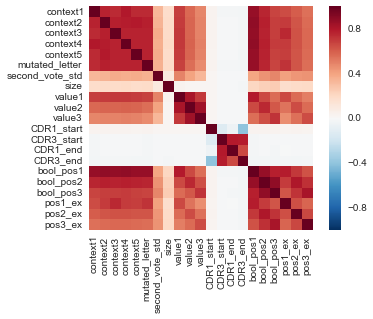

In [322]:
sb.heatmap(data.corr(), square=True)

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


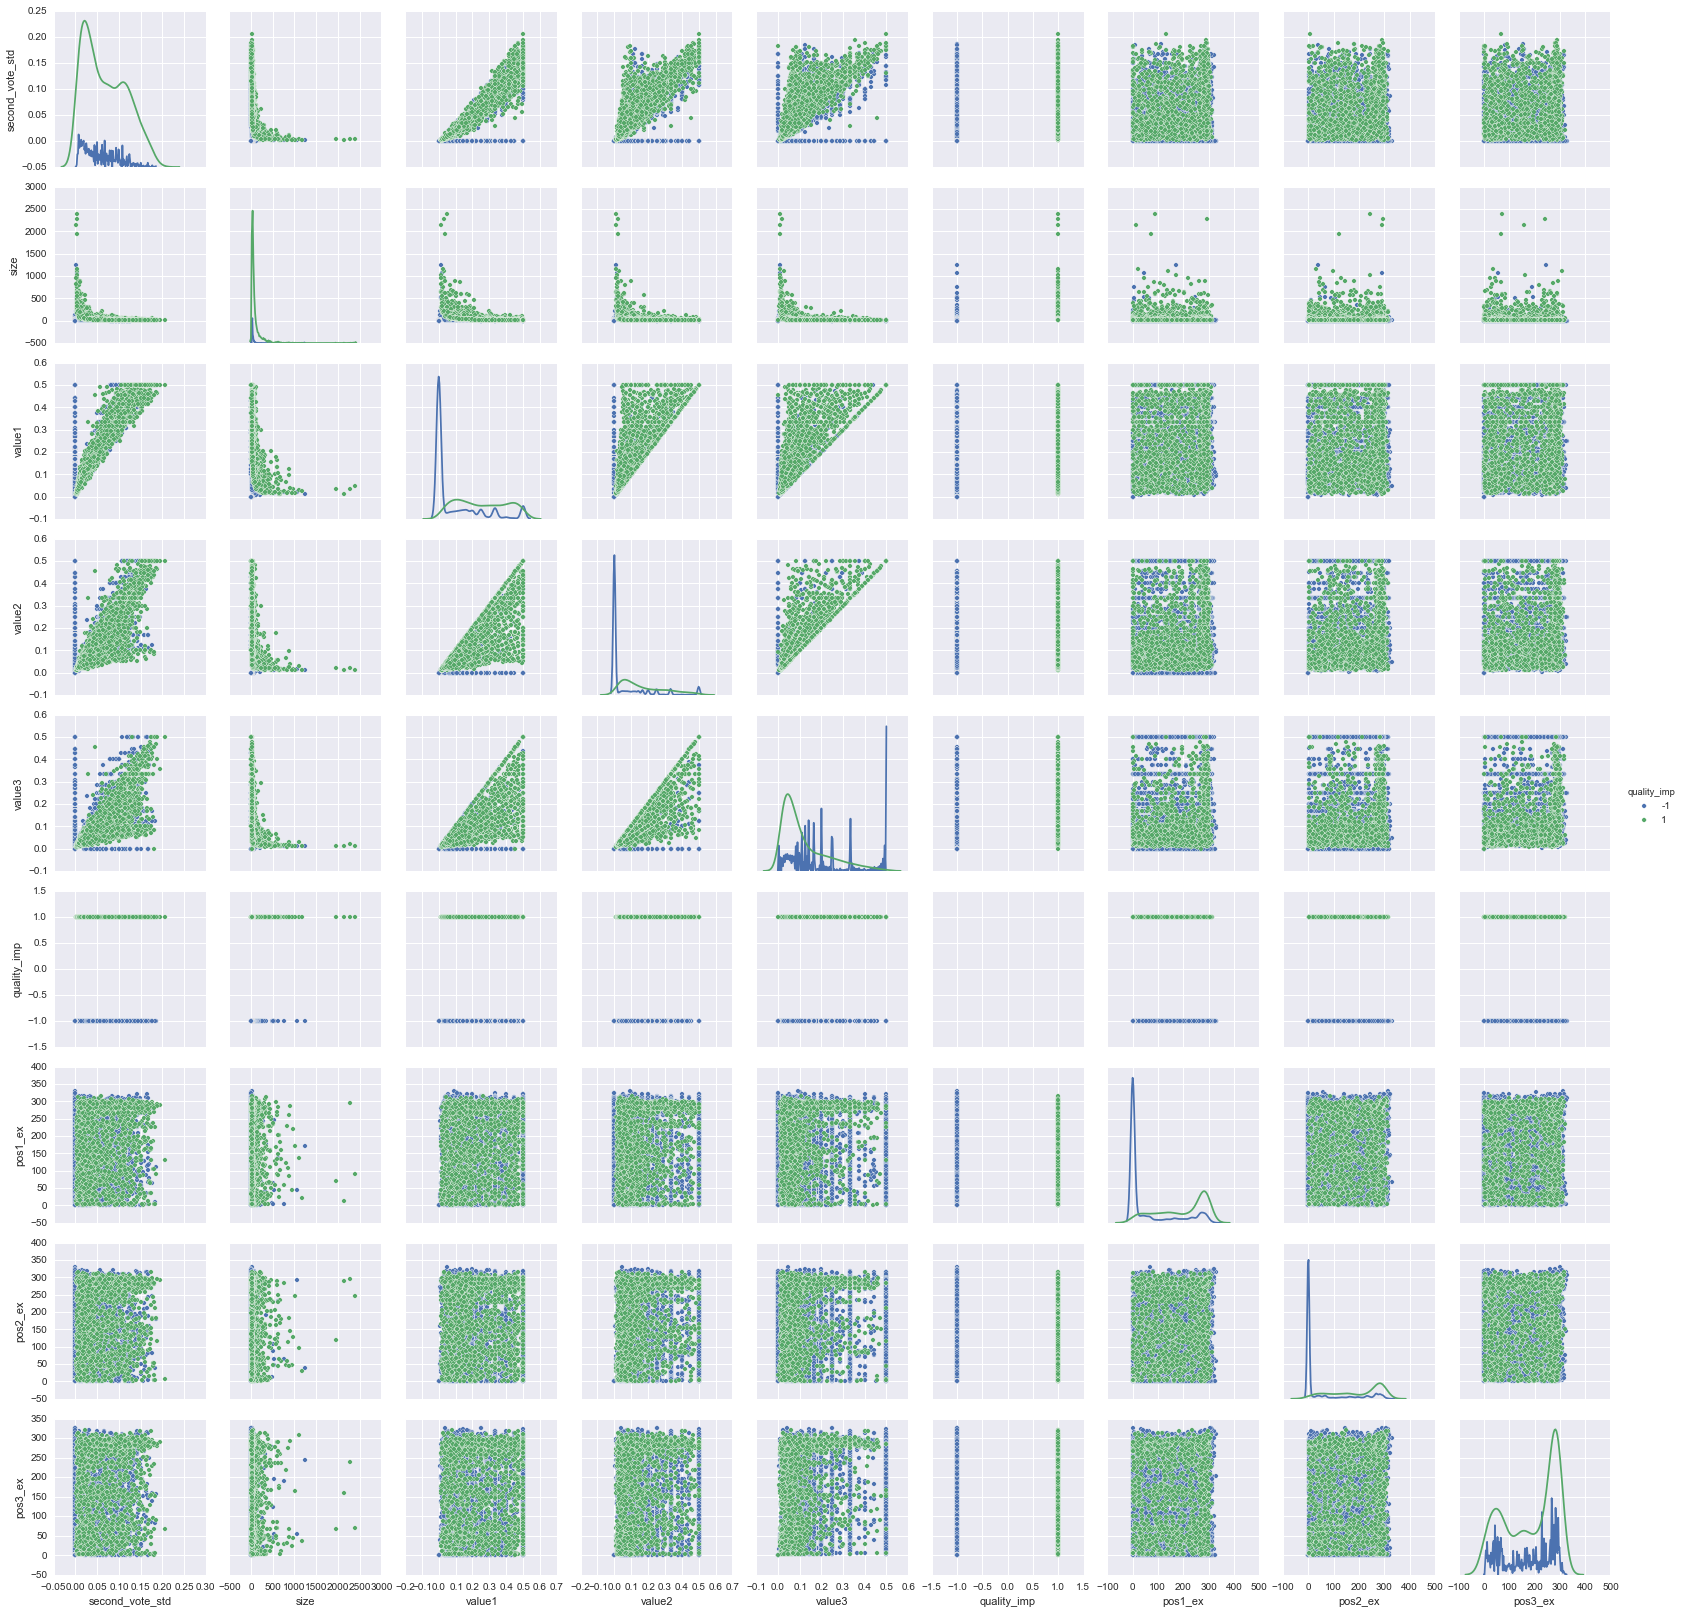

In [321]:
sb.pairplot(temp_df.drop(list(temp_df.columns[:6])+
             ['first_cluster', 'origin_cluster', 'second_cluster']+
             ['CDR1_start', 'CDR2_start', 'CDR3_start']+
             ['CDR1_end', 'CDR2_end', 'CDR3_end']+
             ['bool_pos1', 'bool_pos2', 'bool_pos3'], axis=1), 
            hue='quality_imp',
            diag_kind='kde')

In [326]:
pca = PCA(n_components=23)

In [355]:
data = data[data.CDR2_start != '-']
temp_df = temp_df[temp_df.CDR2_start != '-']

In [343]:
pca_representation = pca.fit_transform(scale(data))

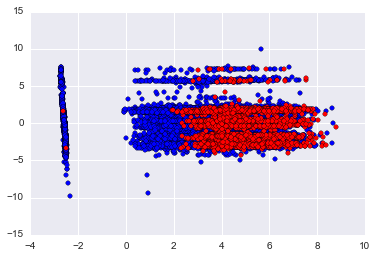

In [344]:
dots = np.array(zip(pca_representation, list(temp_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

<Container object of 23 artists>

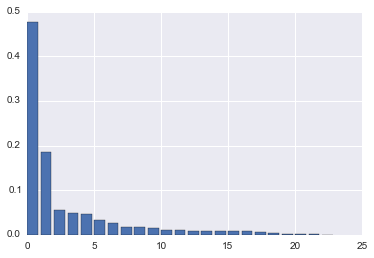

In [346]:
plt.bar(range(23), pca.explained_variance_ratio_)

In [350]:
data.columns[11:17]

Index([u'CDR1_start', u'CDR2_start', u'CDR3_start', u'CDR1_end', u'CDR2_end',
       u'CDR3_end'],
      dtype='object')

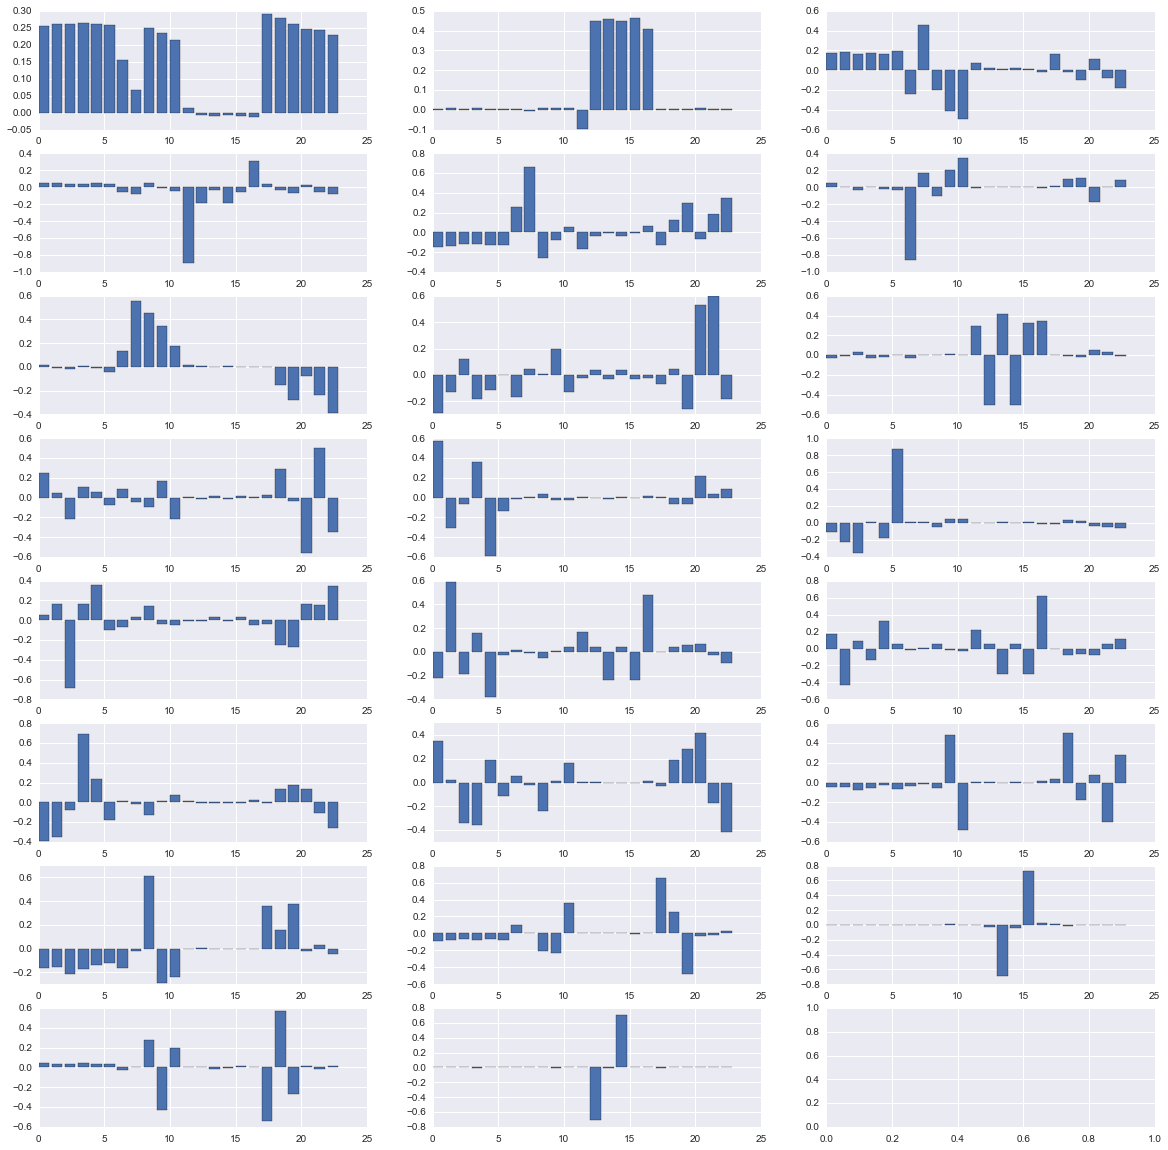

In [348]:
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(20, 20))
for i, vec in enumerate(np.identity(23)): 
    axes[i/3, i%3].bar(range(23),pca.inverse_transform(vec.T))

In [416]:
clf_l = LogisticRegression(penalty='l1')

In [421]:
clf = GridSearchCV(estimator=clf_l, param_grid={'C':np.linspace(1e-10,0.7,10)}, cv=3, scoring='accuracy')

In [422]:
X_train, X_test, y_train, y_test = train_test_split(data, temp_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=temp_df.quality_imp)

In [423]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-10,   7.77778e-02,   1.55556e-01,   2.33333e-01,
         3.11111e-01,   3.88889e-01,   4.66667e-01,   5.44444e-01,
         6.22222e-01,   7.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [425]:
clf.best_estimator_.coef_

array([[  3.21880454e-02,   8.80520665e-02,   3.77815973e-02,
          0.00000000e+00,   3.16330914e-02,  -2.21063778e-02,
          3.58629155e+01,   4.74451147e-02,   1.77408952e+00,
         -2.00015789e+00,  -4.40478472e+00,  -2.27390366e-02,
         -1.69858441e-02,  -1.12410778e-02,   3.32536811e-02,
         -6.78686288e-03,  -1.65312393e-02,   0.00000000e+00,
          0.00000000e+00,   4.67804851e+00,   1.36153506e-03,
          1.60428306e-03,   1.35133861e-03]])

([<matplotlib.axis.XTick at 0x1159d3c50>,
 <a list of 23 Text xticklabel objects>)

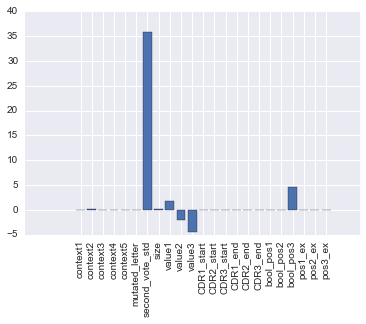

In [426]:
plt.bar(range(23), list(clf.best_estimator_.coef_[0]), align='center')
plt.xticks(range(23), data.columns, rotation=90)

In [446]:
from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [456]:
def logit_p_values(logit_classifier, X, y):
    sse = np.sum((logit_classifier.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    se = np.array([
        np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X)))) for i in range(sse.shape[0])])

    t = self.coef_ / se
    p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
    return (t, p)

In [458]:
sse = np.sum((clf.best_estimator_.predict(X_train) - y_train) ** 2, axis=0) / float(X_train.shape[0] - X_train.shape[1])